# Imports and Constants

In [7]:
import numpy as np
import pandas as pd
import sklearn
import random
import os

from loadData import get_maps, get_masks
from masks import apply_mask_to_maps, get_part_of_maps
from decoding import Decoder

In [8]:
SEED = 0
random.seed(SEED)
classes = ['Up', 'Down', 'Right', 'Left']
nb_runs = 12
length = nb_runs * len(classes)
subjects_ids = range(1, 2)  # TODO modify this to get all subjects (here we only have 1 for the example)

class_labels = [""] * (2 * length)
for i in range(length * 2):
    class_labels[i] = classes[(i // nb_runs) % len(classes)]
labels = dict()
labels["vis"] = np.array(class_labels[:length])
labels["aud"] = np.array(class_labels[length:])

classical_tasks_regions = [(["vis"], ["V5_R", "V5_L"]),
                           (["aud"], ["PT_R", "PT_L"]),
                           (["aud"], ["V5_R", "V5_L"])]

cross_modal_task_regions = [(["vis", "aud"], ["V5_R", "V5_L"])]

classifier = sklearn.svm.SVC(C=1, random_state=SEED)  # default parameters, there is clearly improvements to be
# made here
decoder = Decoder(n_perm=1000, model=classifier, n_classes=len(classes), n_splits=nb_runs, seed=SEED)

# Loading data and decoding

------------------ SUBJECT 1
Loading done
Decoding done


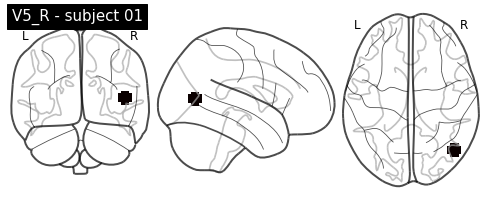

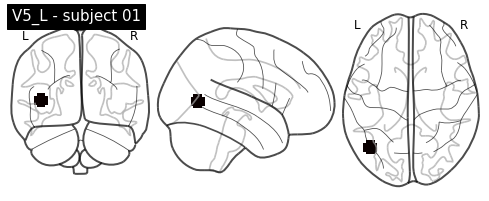

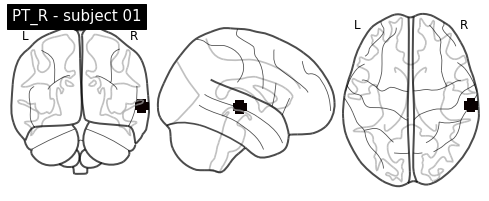

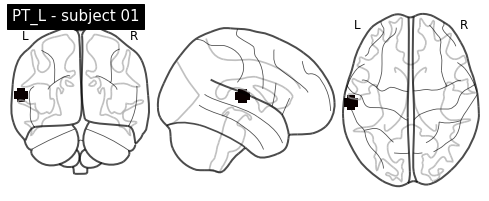

In [6]:
cv_scores = [dict() for _ in subjects_ids]
p_values = [dict() for _ in subjects_ids]
scores_perms = [dict() for _ in subjects_ids]

for i, subj_id in enumerate(subjects_ids):
    print("------------------ SUBJECT " + str(subj_id))
    t_maps, beta_maps = get_maps([subj_id], test = "TEST")
    masks = get_masks([subj_id], plot=True, test = "TEST")
    maps = apply_mask_to_maps(t_maps, masks)
    maps_masked = dict()
    maps_masked["vis"] = get_part_of_maps(maps, 0, length)  # maps acquired for the vision experiment
    maps_masked["aud"] = get_part_of_maps(maps, length, 2 * length)  # maps acquired for the audition experiment

    print("Loading done")
    # classical decoding : training on a task and decoding on other samples from same task
    for tasks, regions in classical_tasks_regions:
        cv_sc, p_val, scores_perm = decoder.classify_tasks_regions(maps_masked, labels, tasks, regions)
        cv_scores[i].update(cv_sc)
        p_values[i].update(p_val)
        scores_perms[i].update(scores_perm)

    # cross-modal decoding : training on a task and decoding on samples from another task
    for tasks, regions in cross_modal_task_regions:
        scores_cross_mod = decoder.cross_modal_decoding(maps_masked, labels, tasks, regions)
        cv_scores[i].update(scores_cross_mod)

    print("Decoding done")

# Saving results

In [9]:
output_directory = "out"
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

In [10]:
df_cv_scores = pd.DataFrame(columns=list(cv_scores[0].keys()))
for score_dico in cv_scores :
    df_cv_scores = df_cv_scores.append(score_dico, ignore_index=True)

df_cv_scores.index = subjects_ids
df_cv_scores.to_csv("out/cv_scores.csv")

In [11]:
df_p_val = pd.DataFrame(columns=list(p_values[0].keys()))
for p_val_dico in p_values :
    df_p_val = df_p_val.append(p_val_dico, ignore_index=True)

df_p_val.index = subjects_ids
df_p_val.to_csv("out/p_values.csv")

In [12]:
df_perms_scores = pd.DataFrame(scores_perms)
df_perms_scores.index = subjects_ids
df_perms_scores.to_csv("out/perms_scores.csv")